## Práctica LSTM-GloVe

In [1]:
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

from torchtext import datasets
from torchtext.data import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe

from sklearn.metrics import accuracy_score, classification_report

EPOCHS = 10 
LEARNING_RATE = 5
GLOVE_DIM = 300

Comenzamos cargando el dataset que vamos a usar.

In [2]:
train_iter, test_iter = datasets.AG_NEWS(split=('train', 'test'))

train_ds = to_map_style_dataset(train_iter)
test_ds = to_map_style_dataset(test_iter)

train = np.array(train_ds)
test = np.array(test_ds)

Creamos el vocabulario que necesitamos.

In [3]:
tokenizer = get_tokenizer("basic_english")

vocab = build_vocab_from_iterator(map(lambda x: tokenizer(x[1]), train_iter), specials=['<pad>','<unk>'])
vocab.set_default_index(vocab["<unk>"])

Creamos los dataloaders que necesitamos.

In [4]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

def collate_batch(batch):
    label_list, text_list = [], []
    for sample in batch:
        label, text = sample
        text_list.append(torch.tensor(text_pipeline(text), dtype=torch.long))
        label_list.append(label_pipeline(label))
    return torch.tensor(label_list, dtype=torch.long), torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab["<pad>"])

train_dataloader = DataLoader(
    train_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

Creamos la clase del modelo sin GloVe

In [5]:
class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)  
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

Creamos la clase del modelo con GloVe

In [6]:
glove = GloVe(name="6B", dim=GLOVE_DIM)

class GloVeTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(GloVeTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)  
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

Creamos un objeto de la clase modelo que creamos antes

In [11]:
model_without_glove = LSTMTextClassificationModel(len(vocab), 32, 64, 4)
model_with_glove = GloVeTextClassificationModel(len(vocab), 300, 64, 4)

Añadimos las funciones que nos permitirá hacer el entrenamiento y el testeo del modelo

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_with_glove = torch.optim.SGD(model_with_glove.parameters(), lr=LEARNING_RATE)
optimizer_without_glove = torch.optim.SGD(model_without_glove.parameters(), lr=LEARNING_RATE)
scheduler_with_glove = torch.optim.lr_scheduler.StepLR(optimizer_with_glove, 1.0, gamma=0.1)
scheduler_without_glove = torch.optim.lr_scheduler.StepLR(optimizer_without_glove, 1.0, gamma=0.1)


def train(dataloader, model, optimizer):
    model.train()
    total_acc, total_count, max_acc = 0, 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| {:5d} batches '
                  '| accuracy {:8.3f}'.format(idx, total_acc / total_count))

            if max_acc < total_acc / total_count:
                max_acc = total_acc / total_count
                
            total_acc, total_count = 0, 0
            start_time = time.time()
    return max_acc


def evaluate(dataloader, model):
    precision, recall, score, accuracy = [], [], [], []
    model_metrics = {"precision": [], "recall": [], "f1-score": [], "accuracy": []}
    model.eval()
    rep = 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            report = classification_report(torch.argmax(predicted_label, dim=1), label, output_dict=True)
            rep += 1
            
            precision.append(report['weighted avg']['precision'])
            recall.append(report['weighted avg']['recall'])
            score.append(report['weighted avg']['f1-score'])
            accuracy.append(accuracy_score(label, torch.argmax(predicted_label, dim=1)))
    return {"precision": sum(precision)/len(precision), "recall": sum(recall)/len(recall), 
            "f1-score": sum(score)/len(score), "accuracy": sum(accuracy)/len(accuracy)}

Entrenamos sin GloVe

In [ ]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    accu_train = train(train_dataloader, model_without_glove, optimizer_without_glove)
    no_glove_model_metrics = evaluate(test_dataloader, model_without_glove)
    
    print("-" * 59)
    print("End of epoch {:3d} | time: {:5.2f}s | Accuracy: {:5.2f}".format(
            epoch, time.time() - epoch_start_time, model_metrics["accuracy"]
        )
    )
    print("-" * 59)

Entrenamos con GloVe

In [15]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    accu_train = train(train_dataloader, model_with_glove, optimizer_with_glove)
    glove_model_metrics = evaluate(test_dataloader, model_with_glove)
    
    print("-" * 59)
    print("End of epoch {:3d} | time: {:5.2f}s | Accuracy: {:5.2f}".format(
            epoch, time.time() - epoch_start_time, glove_model_metrics["accuracy"]
        )
    )
    print("-" * 59)

|   500 batches | accuracy    0.256
|  1000 batches | accuracy    0.253
|  1500 batches | accuracy    0.257


/Users/cayetano/Propio/Notebooks/Machine Learning/RL/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cayetano/Propio/Notebooks/Machine Learning/RL/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cayetano/Propio/Notebooks/Machine Learning/RL/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

-----------------------------------------------------------
End of epoch   1 | time: 52.94s | Accuracy:  0.25
-----------------------------------------------------------


KeyboardInterrupt: 

{'precision': 0.8874640277475048, 'recall': 0.8810399159663865, 'f1-score': 0.8809937473813474, 'accuracy': 0.8810399159663865}


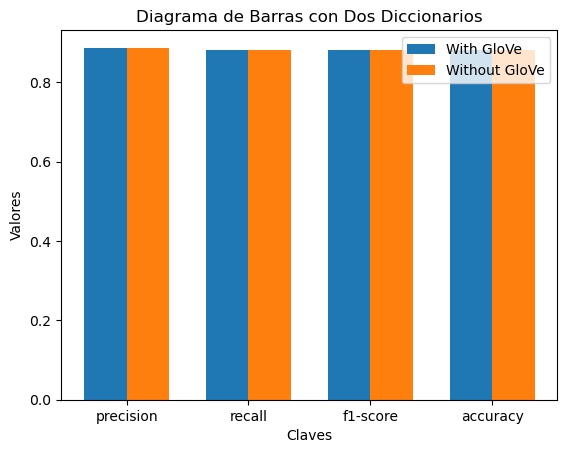

In [ ]:
column_width = 0.35
index = range(len(list(no_glove_model_metrics.keys())))

plt.bar(index, glove_model_metrics.values(), width=column_width, label='With GloVe')
plt.bar([i + column_width for i in index], no_glove_model_metrics.values(), width=column_width, label='Without GloVe')

plt.xlabel("Statics")
plt.ylabel("Values")
plt.title("Last Test Results")
plt.xticks([i + column_width/2 for i in index], list(no_glove_model_metrics.keys()))
plt.legend()
plt.show()
